# Exploratory Data Analysis

&lt; Work in progress &gt;


In [88]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv')#.head(20000) # crop because battery life, skews data
# Make float better readable
pd.options.display.float_format = '{:.0f}'.format

### First Look

In [89]:
df_art.head(3)

,tId,article_id,updated,num_comments,link,header,sub,text
0,31538566,31538566,1502083635,0,/schweiz/news/story/31538566,«Für mich ist eine Welt zusammengebrochen»,Beim Flugzeugunglück bei Pontresina starben dr...,Im Bündner Diavolezza-Gebiet ist ein Flugzeug ...
1,19638181,19638181,1502197771,43,/schweiz/zuerich/story/19638181,Jetzt wird die Schwester der Europaallee gebaut,Gleisarena und Gleistribüne  so heissen die e...,Die neue Überbauung HB-Nord entsteht nördlich ...
2,31833243,31833243,1502299764,0,/schweiz/basel/story/Fuenffacher-Nachwuchs-im-...,Fünffacher Nachwuchs im Basler Affenhaus,Bei den Totenkopfäfflein im Basler Zoo gibt es...,Die fünf Totenkopfäffchen wurden zwischen Mitt...


In [90]:
df_com.head(3)

,tId,cId,mob,vup,vdo,tit,aut,time,con
0,24298157,3_127,1,2,0,@Thomas,Spaniel,am 21.07.2017 12:14,Es würde Streit geben wenn er aufgespannt wir...
1,13753138,1115_1225,0,21,1,ohne Partikelfilter,Heinz B.,am 05.08.2017 17:25,@Historiker: Aber im Gegensatz zu Baumaschine...
2,13340147,783_783,1,87,14,Nur Abzocker,KChav,am 09.08.2017 15:45,Jetzt kann die Zürcher Taxi Maffia wieder los...


In [91]:
print(df_art.shape)
print(df_com.shape)

(1026, 8)
(77611, 9)


In [92]:
print(df_art.dtypes)
print(' ')
print(df_com.dtypes)

tId               int64
article_id        int64
updated         float64
num_comments      int64
link             object
header           object
sub              object
text             object
dtype: object
 
tId      int64
cId     object
mob      int64
vup      int64
vdo      int64
tit     object
aut     object
time    object
con     object
dtype: object


In [93]:
df_art.describe()

# Summary:
# No missing attributes since count is the same everywhere
# No negative values, chi^2 etc. can be used

,tId,article_id,updated,num_comments
count,1026,1026,1026,1026
mean,21144399,21143338,1502274052,77
std,6430672,6435194,129408,136
min,10003016,10003016,1502017728,0
25%,15604268,15604268,1502172556,0
50%,21220790,21220790,1502288367,28
75%,26632181,26655490,1502414371,84
max,31996579,31996579,1502425549,1171


In [94]:
df_com.describe()

# Summary:
# No missing attributes 
# No negative values

,tId,mob,vup,vdo
count,77611,77611,77611,77611
mean,20855978,1,45,16
std,6423375,0,120,34
min,10003016,0,0,-1
25%,15232299,0,7,2
50%,20500325,1,20,6
75%,26730000,1,45,16
max,31996579,1,3799,1072


In [95]:
print(df_art.skew())
# Makes only sense on 'num_comments'

tId             0
article_id      0
updated        -0
num_comments    3
dtype: float64


In [96]:
print(df_com.skew())
# Skew is not high enough that it has to be corrected

tId    0
cId    3
mob   -1
vup   12
vdo    8
dtype: float64


### Feature Engineering
To make further analysis possible concerning time features.

In [97]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

### Class Distribution

In [98]:
# 'df_art' has no classes

# 'df_com' 
print(df_com.groupby('mob').size())
#print(df_com.groupby('hour').size())
print(df_com.groupby('weekday').size())

mob
0    25113
1    52498
dtype: int64
weekday
0     6910
1    11459
2    16916
3    14357
4     9050
5     9361
6     9558
dtype: int64


### Correlation
Let's find relations between some of the attributes. Correlation requires continuous data.

In [99]:
# Only for these columns
cols = ['score', 'contr', 'hour', 'weekday', 'weekday_fl', 'mob', 'vup', 'vdo', 'is_answer', 'con_len']

# Change back how float is displayed
pd.options.display.float_format = '{:.2f}'.format

# Get pearson co-efficients
df_corr = df_com[cols].corr()
df_corr

# Summary:
# Correlations are low.
# The only interesting correlation is between 'vup' and 'vdo'.

,score,contr,hour,weekday,weekday_fl,mob,vup,vdo,is_answer,con_len
score,1.00,0.87,-0.01,-0.01,-0.01,0.04,0.96,0.10,-0.14,0.01
contr,0.87,1.00,-0.01,-0.01,-0.02,0.08,0.97,0.59,-0.21,0.02
hour,-0.01,-0.01,1.00,-0.00,0.12,0.03,-0.01,-0.01,0.03,-0.06
weekday,-0.01,-0.01,-0.00,1.00,0.99,0.07,-0.01,-0.01,0.06,-0.01
weekday_fl,-0.01,-0.02,0.12,0.99,1.00,0.07,-0.01,-0.01,0.06,-0.01
mob,0.04,0.08,0.03,0.07,0.07,1.00,0.07,0.09,0.32,-0.12
vup,0.96,0.97,-0.01,-0.01,-0.01,0.07,1.00,0.38,-0.18,0.01
vdo,0.10,0.59,-0.01,-0.01,-0.01,0.09,0.38,1.00,-0.19,0.01
is_answer,-0.14,-0.21,0.03,0.06,0.06,0.32,-0.18,-0.19,1.00,-0.13
con_len,0.01,0.02,-0.06,-0.01,-0.01,-0.12,0.01,0.01,-0.13,1.00


### Scatter plots

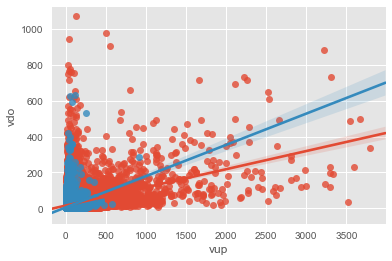

In [100]:
#sns.pairplot(df_com, x_vars='vup', y_vars='vdo', size=6)
sns.regplot(x='vup', y='vdo', data=df_com[df_com['is_answer'] == False])
sns.regplot(x='vup', y='vdo', data=df_com[df_com['is_answer'] == True])
plt.show()

# Quite some outliers
# Are rows with upvotes of over 1000 real?
# Looked some of them up manually and yes, they have a lot of upvotes (3000+)
# Answers are rather downvoted than upvoted (as can already be seen in the correlation matrix)

In [101]:
#sns.regplot(x='vup', y='vdo', data=df_com[df_com['vup'] < 200])
#sns.regplot(x='con_len', y='score', data=df_com)
#plt.show()

### Prediction
Ok... I want to know:
* How to get the best score/consensus (upvotes - downvotes)?
* How to be most controversial (upvotes + downvotes)?
* Which articles go most score / were most controversial (sum over all comments)?

...And in the end I want a model predicting my comment text with given day and hour of posting.

Impact will be taken into account from:
* Hour of comment
* Weekday
* Weekday + hour = Hour of week
* text written
* title written / if title is an answer (starts with "@")
* if from mobile (makes no sense, but let's see what happens)
* article text
* article category
* ...?

Problem:
* Some parts are computationally expensive / the ipython kernel has problems running it sometimes

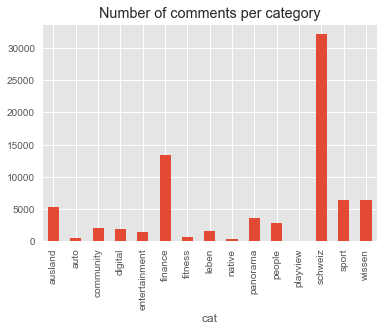

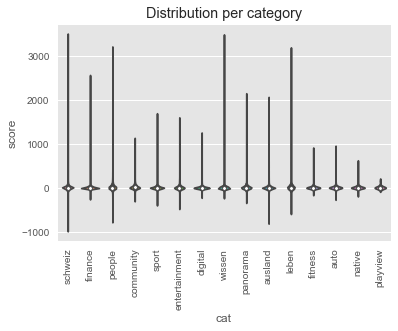

In [102]:
df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Hist
h = df_merge.groupby(['cat']).size()
h.plot.bar(title='Number of comments per category')
plt.show()

# Distribution
ax = sns.violinplot(x="cat", y="score", data=df_merge)
ax.set_title('Distribution per category')
plt.xticks(rotation = 90)
plt.show()

# Part of mobile users, not interesting enough
#parts_mob = df_merge[df_merge['mob'] == True].groupby(['cat']).size() / df_merge.groupby(['cat']).size()
#parts_mob.plot.bar(title='Mobile comments per category')
#plt.show()

# is empty: (= all comments correspond to an article)
#print(df_merge[pd.isnull(df_merge['link'])])
#df_merge[df_merge['vup']>1000]

# Get order of comments per article
df_merge_art = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')
# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    group = group[group['time_since_first'] < 36]
    return group

df_merge_art = df_merge_art.apply(get_time_since_first)

df_merge_art = df_merge_art[df_merge_art['score'] < 1000]

#ax = sns.regplot(x='time_since_first', y='contr', label='contr', data=df_merge_art)
#ax = sns.regplot(x='time_since_first', y='score', label='score', data=df_merge_art)
#ax.legend()
#plt.show()

    
# Summary:
# Score / contr are only possible in certain categories 
#    - the categories with lots of active users
#    - probably the categories with lots of comments (see hist)
# The time of posting compared to the first comment is not as important as I expected it to be
# Exception: Some early comments make it into "top comments" and get very high scores/contr
# But we can say the comment has to be posted about < ~12h after the first comment

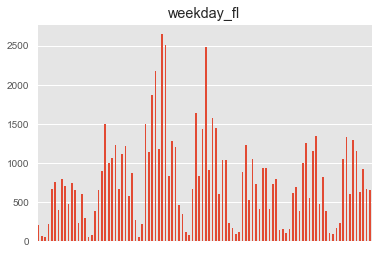

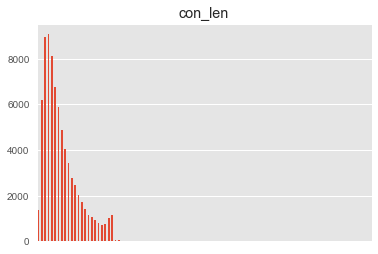

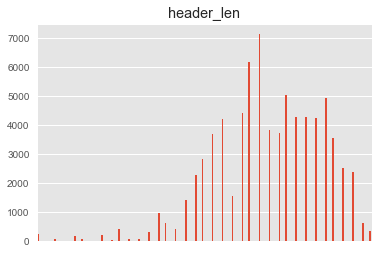

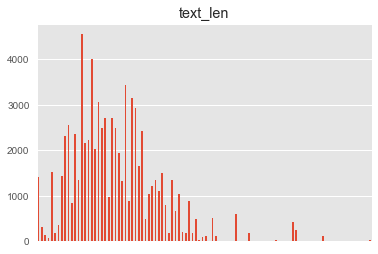

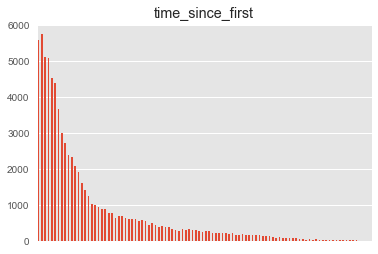

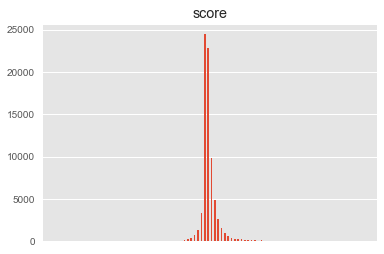

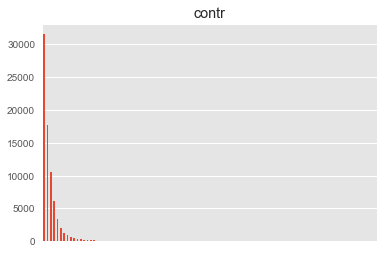

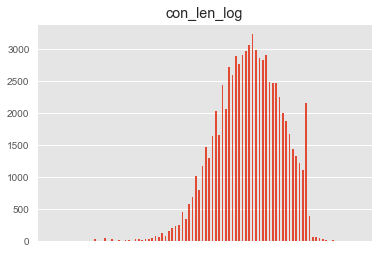

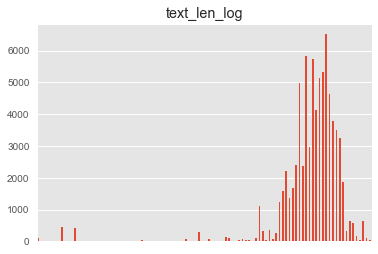

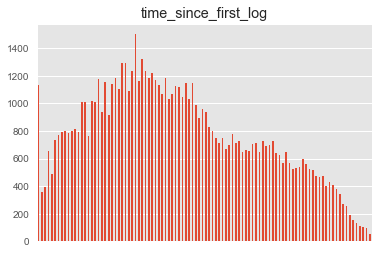

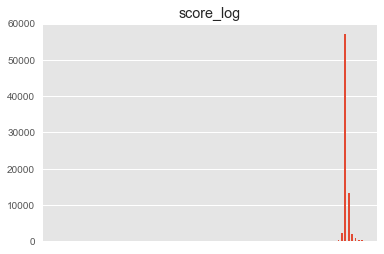

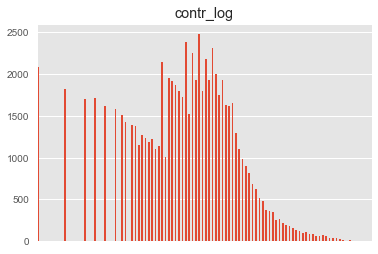

In [103]:
# Try around to see how columns are distributed
# And do some feature engineering
import math

def show_hist(col):
    df_merge_art['bins'] = pd.cut(df_merge_art[col], 100)
    h = df_merge_art.groupby(['bins']).size().plot.bar(title=col)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()

'''
from sklearn.preprocessing import Normalizer, RobustScaler, MinMaxScaler
#scaler = Normalizer()
scaler = RobustScaler(quantile_range=(25, 75))
df_merge_art['score_scaled'] = scaler.fit_transform(df_merge_art['score'])
#print(df_merge_art['score_scaled'])
#show_hist('score_scaled')
'''
#max_val = df_merge_art['weekday_fl'].max()
#df_merge_art['weekday_fl_arcsin'] = df_merge_art['weekday_fl'].apply(lambda x: math.asin(x/max_val))
    
for col in ['weekday_fl', 'con_len', 'header_len', 'text_len', 'time_since_first', 
            'score', 'contr']:
    show_hist(col)
    
for col in ['con_len', 'text_len', 'time_since_first', 'score', 'contr']:
    min_val = df_merge_art[col].min()
    df_merge_art[col + '_log'] = df_merge_art[col].apply(lambda x: math.log(x+1-min_val))
    show_hist(col + '_log')
    
# Log doesn't work on score, the outliers are too extreme

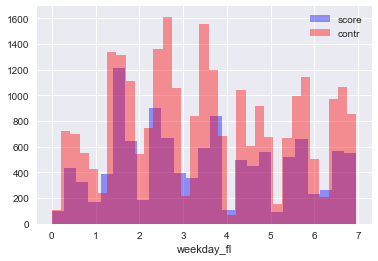

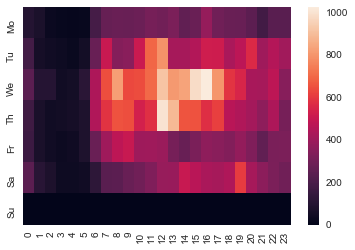

,score,contr,weekday_fl,con_len,con_len_log,time_since_first,time_since_first_log
score,1.00,0.73,-0.02,0.02,0.03,-0.15,-0.22
contr,0.73,1.00,-0.02,0.03,0.04,-0.22,-0.30
weekday_fl,-0.02,-0.02,1.00,-0.02,-0.02,0.09,0.11
con_len,0.02,0.03,-0.02,1.00,0.90,0.04,0.05
con_len_log,0.03,0.04,-0.02,0.90,1.00,0.04,0.04
time_since_first,-0.15,-0.22,0.09,0.04,0.04,1.00,0.91
time_since_first_log,-0.22,-0.30,0.11,0.05,0.04,0.91,1.00


In [117]:
# Plot hist and heat map against weekdays
weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']

sns.set(color_codes=True)
ax = sns.distplot(df_com[df_com['score']>50]['weekday_fl'], label='score', kde=False, color='blue')
ax = sns.distplot(df_com[df_com['contr']>50]['weekday_fl'], label='contr', kde=False, color='red')
#ax.set(xticks=range(0, len(weekdays)), xticklabels=weekdays) # This is misleading
ax.legend()
plt.show()

grouped = df_com[df_com['score']>0].groupby(['weekday', 'hour']).size()
matrix = np.zeros((7, 24))
for d in range(0, 6):
    for h in range(0, 24):
        if d in grouped and h in grouped[d]:
            matrix[d][h] = grouped[d][h]

sns.heatmap(matrix, yticklabels=weekdays)
plt.show()

# I removed very weak correlations to "score" and "contr"
cols = ['score', 'contr', 'weekday_fl', 'con_len',
       'con_len_log',
       'time_since_first', 'time_since_first_log']
# Get pearson co-efficients
df_merge_art[cols].corr()


# 0 = Monday, 7 = Sunday
# Summary:
# The day and time of posting plays a big role
# This is probably because on certain days upvoting people are most active
# This does not mean that posting the *same* comment on those times gives you more upvotes
# - it may be possible, but we can't imply that (yet? / not enough data)

In [105]:
# Preprocess and split data

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Prepare data for X and y
#from sklearn.feature_extraction.text import CountVectorizer

# Preprocessor removes numbers
#no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
#vect = CountVectorizer(preprocessor=no_numbers, ngram_range=(1, 1), stop_words=stop_words) # Range higher than 1 doesn't help

def classify(val):
    if val > 50: return 1
    return 0

# TODO split this?
# For comments
if True:
    # Basically drop columns "score" and "contr"
    columns = ['weekday', 'hour', 'time_since_first', 'time_since_first_log', 
               'con_len', 'con_len_log', 'header_len', 'text_len', 'text_len_log']
    X = df_merge_art[columns + ['con', 'text']]

    #y = df_merge_art['score'].apply(classify)
    y = df_merge_art['score']
# For articles, some articles have no text
#else:
#    X = vect.fit_transform(df_merge[pd.notnull(df_merge['text'])]['text'])
#    y = df_merge[pd.notnull(df_merge['text'])]['score'].apply(classify)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Summary:
# Removing stop words didn't help the score (didn't add information), 
#   but it makes the model easier to interpret
# N-gram over 1 doesn't give a better score
# min_df / max_df in CountVectorizer make no difference

In [106]:
# Build a simple intermediate model for text
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge

#voc = ['ich', 'es', 'guet', 'schlecht', 'nicht', 'nein']
#vect = CountVectorizer(vocabulary=voc)
#print(vect.vocabulary_)

no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
vect = CountVectorizer(preprocessor=no_numbers, min_df=0.1, max_df=0.4, max_features=100)
sent_model = make_pipeline(vect, Ridge(max_iter=10, alpha=10000, solver='lsqr'))
sent_model.fit(X_train['con'], y_train)
y_pred = sent_model.predict(X_test['con'])
print("R^2: %1.3f\n" % r2_score(y_test, y_pred))

if True:
    coeff_by_name = {}
    for i, f in enumerate(sent_model.named_steps['countvectorizer'].get_feature_names()):
        coeff_by_name[f] = sent_model.named_steps['ridge'].coef_[i]

    coeff_sorted = sorted(coeff_by_name.items(), key=lambda x:x[1], reverse=True)
    for c in coeff_sorted[0:30]:
        print("{}\t{}".format(c[0], c[1]))
    print("----------")
    for c in coeff_sorted[-30:]:
        print("{}\t{}".format(c[0], c[1]))
    
if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'countvectorizer__max_features': [100, 200],
        'ridge__alpha': np.logspace(-1, 3, 5), 'ridge__max_iter': [10, 50, 100], 
                  'ridge__solver': ['svd', 'cholesky', 'lsqr']}
    grid = GridSearchCV(sent_model, param_grid, cv=3)
    grid.fit(X_train['con'], y_train)
    
    print("Best estimator:\n{}".format(grid.best_estimator_))

R^2: 0.002

man	2.195889289570573
dass	1.578051628508537
werden	1.5648783009470117
sich	1.5525340461285448
eine	1.3308667913685623
mehr	1.1598933328813372
für	1.0716189833851655
dem	1.0648551191590048
in	1.0251190001491848
auf	1.0100108221066502
was	0.8018745320466759
zu	0.6915794940329206
wie	0.6254994934092236
noch	0.4606690134666732
das	0.4606124778797206
so	0.35521527683912857
als	0.3122242089051538
kann	0.2958599570627135
ein	0.285364356343044
ich	0.2487142535995381
den	0.24687560899557862
da	0.1939597791319575
sind	0.1589145953749552
es	0.15166646443393703
haben	0.1324817929212939
wenn	0.0889335196843385
wird	0.04084119475982235
schon	-0.00026889947047384604
der	-0.07465572456691125
nicht	-0.11392133828781156
----------
noch	0.4606690134666732
das	0.4606124778797206
so	0.35521527683912857
als	0.3122242089051538
kann	0.2958599570627135
ein	0.285364356343044
ich	0.2487142535995381
den	0.24687560899557862
da	0.1939597791319575
sind	0.1589145953749552
es	0.15166646443393703
haben	0.1

In [119]:
# Build a prediction model and test it
# Not all imports needed - trying around
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge
#from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
#from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list=
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 
                         'time_since_first_log'])),
                ('scaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=5))
            ])),
            
            # Course of dimensionality!
            ('words', Pipeline([
                ('selector', ItemSelector(key='con')),
            #    ('vect', CountVectorizer(preprocessor=no_numbers, ngram_range=(1, 1), stop_words=stop_words))
                ('sent_model', sent_model)
            ]))
        ],
        
        transformer_weights={
            'statistics': .8,
            'words': .2
        }
    )),
    
    # Params not optimized yet
    ('model', Ridge())
    #('model', SVC(kernel='linear', n_jobs=-1))
])

#model = make_pipeline(ItemSelector(
#        key=['weekday', 'hour', 'time_since_first', 'con_len']),
#        StandardScaler(), PolynomialFeatures(degree=5), Ridge(alpha=100, max_iter=10, solver='cholesky'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f\n" % r2_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

'''
# See influence of the polynomial features
print(columns)
features = {}
for i, feature in enumerate(model['union'].named_steps['polynomialfeatures'].get_feature_names()):
    features[feature] = model.named_steps['ridge'].coef_[i]

for name, value in sorted(features.items(), key=lambda x:x[1], reverse=True):
    print("{}\t{}".format(name, value))
'''

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5],
        'ridge__alpha': np.logspace(-1, 4, 6), 'ridge__max_iter': [10, 50, 100], 'ridge__solver': ['svd', 'cholesky', 'lsqr']}
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    
    print("Best estimator:\n{}".format(grid.best_estimator_))
    #print("Best coefficients:\n{}".format(grid.best_estimator_.named_steps["ridge"].coef_))

ValueError: not enough values to unpack (expected 2, got 0)

### Take Aways so far
Context seems to play a big role in determining up/downvotes, a far bigger role than words used. - This is not surprising, since the number of active readers differs a lot and since words can change their meaning depending on context.  
So maybe the content is not that important, maybe it's more important if it is positive or negative?  
Hypothesis: Earlier comments on an article get more score/contr than later ones; at least there is a weak correlation.